# Problem Description

The goal of this exercise is to create an algorithm/model that can identify metastatic cancer in images taken from pathology scans as accurately as possible. There are two dat sets provided, a test set and a train set. A Convolutional Neural Netork with a binary classification function is to be used to identify cancer. The accuracy scores will be compared with other submittals to kaggle's competition.  

# Exploratory Data Analysis

In [282]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Cropping2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

The data gets imported, and to aid in interpretation a text label is added to the training data to identify benign images vs. malignant images. A plot was also created to compare the distribution of benign vs. malignant images in the data. 

<Axes: xlabel='label_category'>

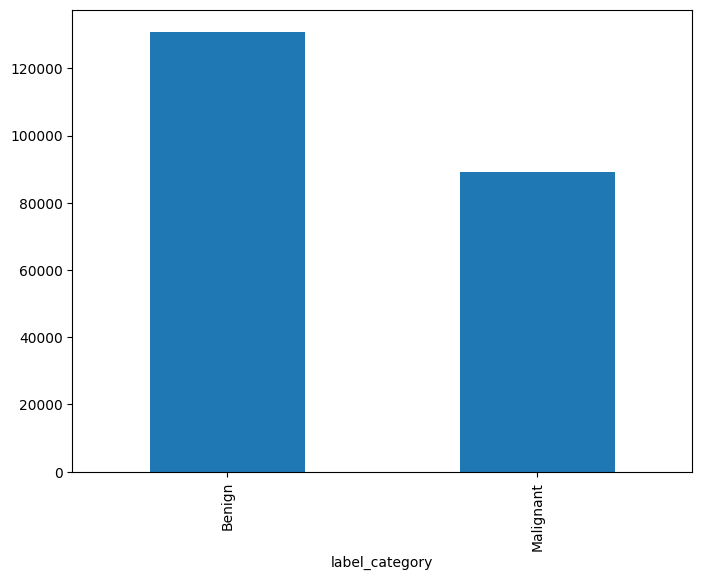

In [263]:
train_label_df = pd.read_csv('train_labels.csv')
train_label_df['label_category'] = train_label_df['label'].map({0: 'Benign', 1: 'Malignant'})

label_counts = train_label_df['label_category'].value_counts()
plt.figure(figsize=(8,6))
label_counts.plot(kind='bar')

There is a class imbalance in the training data set. There are a few techniques that can be used to adjust for that, including resampling methods and adjusting the weights in the weighted loss function (assigning higher weights to the malignant class to penalize the misclassification of the minority class more heavily). These techniques will be addressed later in the problem.  

The data set was also checked for duplciates or missing values below.  

In [264]:
# Check for missing vals or duplicates:
print("Duplicate Observations:", train_label_df.duplicated().sum())
print("Missing Values:", train_label_df.isnull().sum())

Duplicate Observations: 0
Missing Values: id                0
label             0
label_category    0
dtype: int64


Import the images for the training and testing, and verify there are the same number of images are there are labels for the test data. 

In [265]:
# Import the train and test images
train_img = os.listdir('train/')
test_img  = os.listdir('test/')
print("No. training images", len(train_img))
train_label_df.info()

No. training images 220025
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              220025 non-null  object
 1   label           220025 non-null  int64 
 2   label_category  220025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


Check the data to ensure it imported as expected and also check the unique valuse in the 'label' column. 

In [266]:
print(train_label_df.head())
print(train_label_df.columns)
print(train_label_df['label'].unique()) 

                                         id  label label_category
0  f38a6374c348f90b587e046aac6079959adf3835      0         Benign
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1      Malignant
2  755db6279dae599ebb4d39a9123cce439965282d      0         Benign
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0         Benign
4  068aba587a4950175d04c680d38943fd488d6a9d      0         Benign
Index(['id', 'label', 'label_category'], dtype='object')
[0 1]


Preview a sample of the images to see if its possible to easily discern the difference between those that are benign and those that are malignant. 

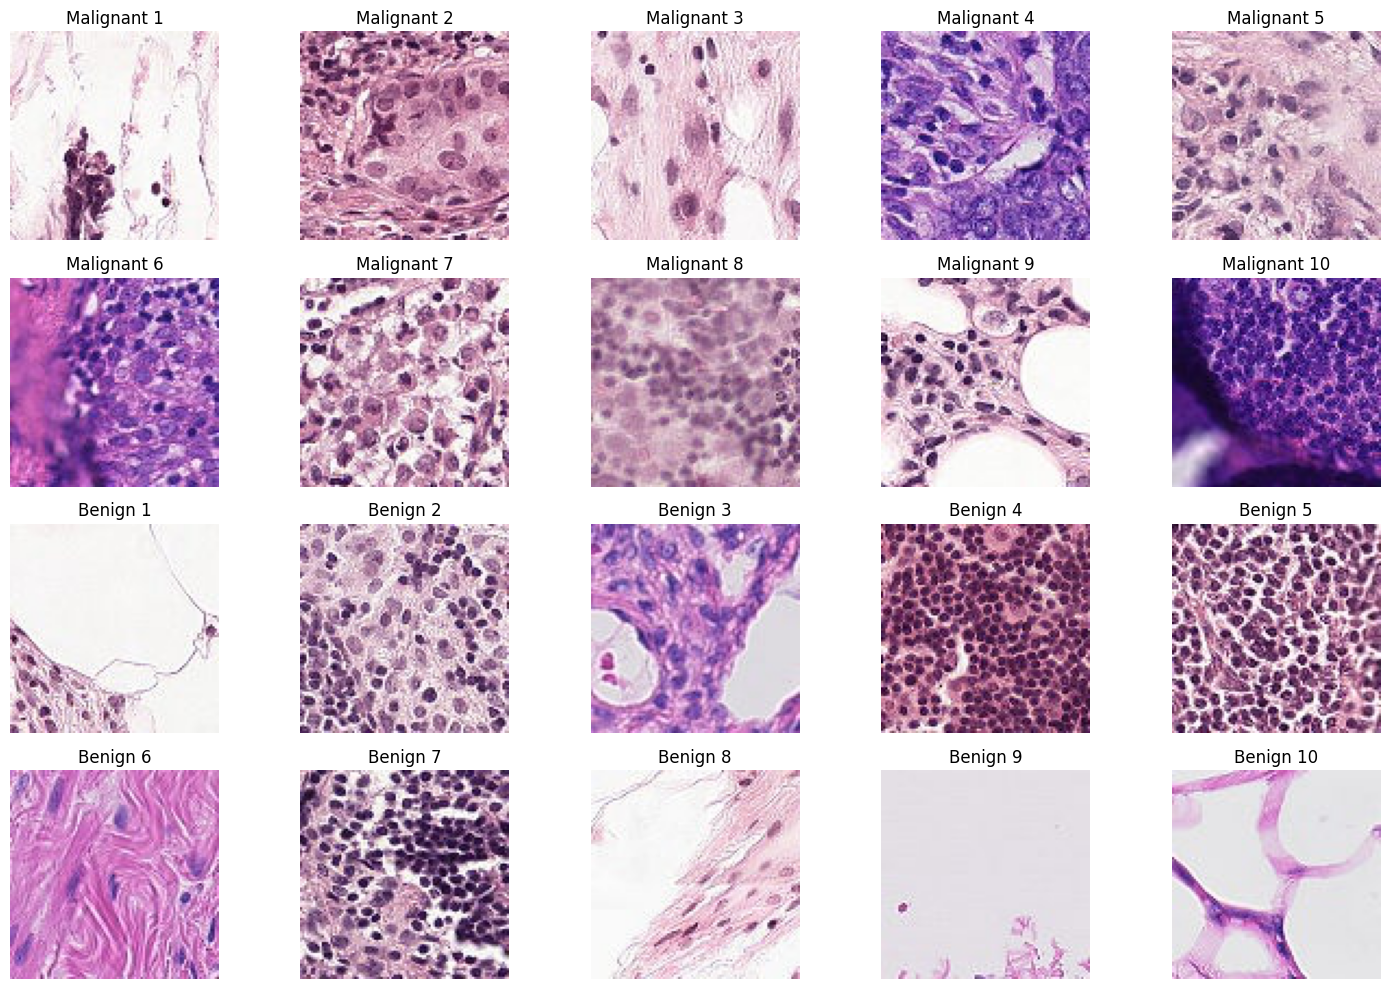

In [243]:
image_folder = 'train/'
malignant_images = train_label_df[train_label_df['label_category'] == 'Malignant'].head(10)
benign_images = train_label_df[train_label_df['label_category'] == 'Benign'].head(10)

plt.figure(figsize=(15, 10))

# Display malignant images
for i, img_id in enumerate(malignant_images['id']):
    img_path = os.path.join(image_folder, img_id + '.tif')
    img = Image.open(img_path)
    plt.subplot(4, 5, i + 1) 
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"Malignant {i + 1}")


# Display benign images
for i, img_id in enumerate(benign_images['id']):
    img_path = os.path.join(image_folder, img_id + '.tif') 
    img = Image.open(img_path)
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"Benign {i + 1}")

plt.tight_layout() 
plt.show()

I'm unable to detect any discrepancies between the malignant and benign samples images when considering all images in each group. All of the malignant images appear to have smaller dark spots, but so do the majority of the begnign ones. 

The last EDA step is to verify the size of the images and the mode. We can see the size is 96x96px with a mode of RGB, so 3 channels. The problem indicates that the center 32x32px are to be analyzed, so the images will need to be adjusted at some point in the analysis.  

In [267]:
print(img.size)
print(img.mode)

(96, 96)
RGB


# Model Building and Training

The images were first cropped to 32x32px per the kaggle instructions and then loaded into arrays. 

In [268]:
# Crop the image data
def crop_center(image, crop_size=32):
    width, height = image.size
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    return image.crop((left, top, right, bottom))

X_train = []
y_train = []

for idx, row in train_label_df.iterrows():
    img_id = row['id']
    label = row['label'] #label = row['label_category']
    img_path = os.path.join(train_image_folder, img_id + '.tif')
    
    # Load the image
    img = Image.open(img_path)
    
    # Crop to 32x32
    cropped_img = crop_center(img, crop_size=32)
    
    # Convert the to array and normalize
    img_array = np.array(cropped_img) / 255.0
    
    X_train.append(img_array)
    y_train.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

Separate the training data into a training and test data set, then instantiate and train the model. 

In [246]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [247]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 2304)              0         
                                                                 
 dense_52 (Dense)            (None, 128)             

The architecture of the first model created is noted above, with three convolution and max pooling layers and using dropout to prevent overfitting. The epoch count was set to 10 and batch size set to 30. For the first model, the full data set was used, which took an extremely long time (relatively speaking for this exercise) to train the model using my CPU. No early stop parameters were used, and in the below output it shows that the validation loss stagnated a bit and the validation accuracy didn't show significant improvement after the first 4-5 epochs. The code to train the model has been uncommented out and an image of the output pasted due to the time it takes to run. It can be uncommented and ran to validate. 

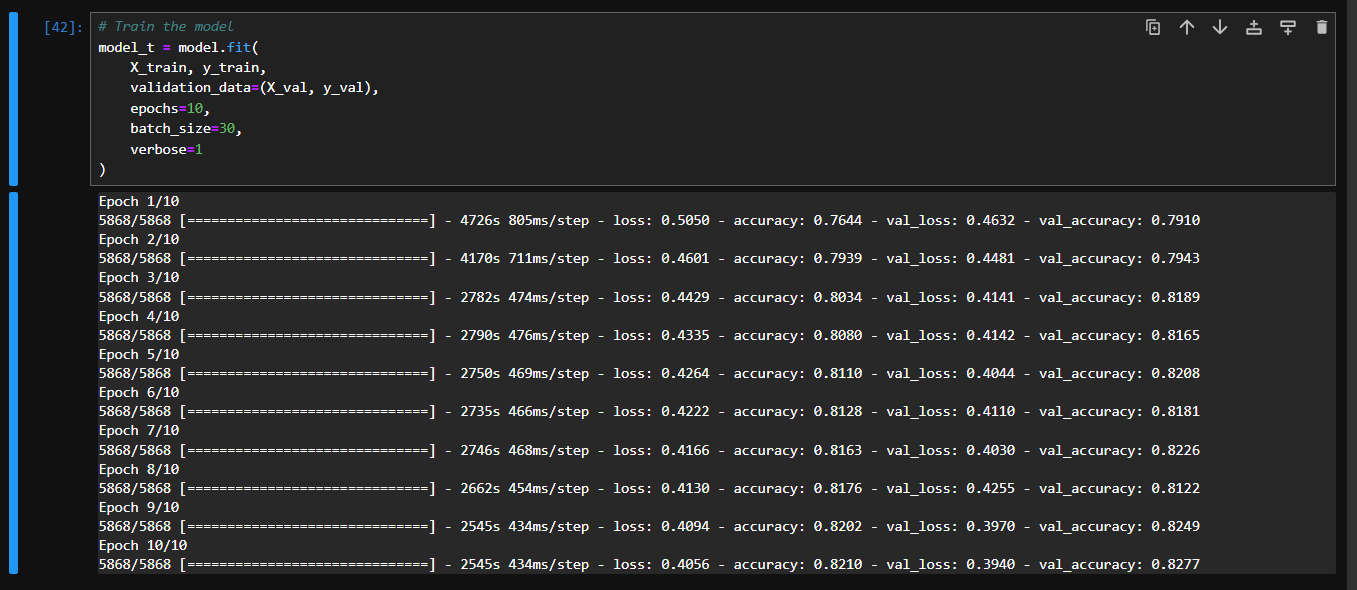

In [248]:
# Train the model
# UNCOMMENT to RUN
# model_t = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=10,  
#     batch_size=30,  
#     verbose=1
# )

In an attempt to improve the training efficiency of the model but also improve the accuracy, a sub-sample of the data was taken (~10%), and a new, deeper CNN model was created.

In [269]:
benign_subsample = train_label_df[train_label_df['label'] == 0].sample(n=22000, random_state=13, replace=False)
malignant_subsample = train_label_df[train_label_df['label'] == 1].sample(n=22000, random_state=13, replace=False)
train_subsample = pd.concat([benign_subsample, malignant_subsample], axis=0).sample(frac=1, random_state=13).reset_index(drop=True)

In [270]:
# Crop the image data
def crop_center(image, crop_size=32):
    width, height = image.size
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    return image.crop((left, top, right, bottom))

X_sub_train = []
y_sub_train = []

for idx, row in train_label_df.iterrows():
    img_id = row['id']
    label = row['label']
    img_path = os.path.join(train_image_folder, img_id + '.tif')
    
    # Load the image
    img = Image.open(img_path)
    
    # Crop to 32x32
    cropped_img = crop_center(img, crop_size=32)
    
    # Convert the to array and normalize
    img_array = np.array(cropped_img) / 255.0
    
    X_sub_train.append(img_array)
    y_sub_train.append(label)

# Convert lists to numpy arrays
X_sub_train = np.array(X_sub_train)
y_sub_train = np.array(y_sub_train)

In [251]:
X_sub_train, X_sub_val, y_sub_train, y_sub_val = train_test_split(X_sub_train, y_sub_train, test_size=0.2, random_state=13)

In [252]:
model_2 = Sequential([
    Input(shape=(32, 32, 3)),
    # layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #layer 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #layer 5
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model_2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_61 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_62 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

The model above, model_2, proved to be too resource intensive for the purposes of this exercise, so the training operation was terminated early and a third model was created using the format suggested in class: where two convolution layers were linked then a max pooling layer for each block of the CNN model. This was repeated for 3 blocks with the Adam optimizer and a learning rate of 0.001. The number of epochs was increased but a stop parameter was also implemented as seen below. 

In [260]:
model_3 = Sequential([
    # Input layer
    Input(shape=(32, 32, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'), 
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D((2, 2)), 

    
    Conv2D(64, (3, 3), activation='relu', padding='same'), 
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), 

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model_3.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print the model summary
model_3.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_88 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_118 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_89 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

In [261]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), # wait 3 epochs for the val_loss to improve
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss') # save the best model
]

model_t3 = model_3.fit(
    X_sub_train, y_sub_train,
    validation_data=(X_sub_val, y_sub_val),
    epochs=20,  # increased this despite the first model because of the early stop parameter
    batch_size=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
4694/4694 [==============================] - 19649s 4s/step - loss: 0.4771 - accuracy: 0.7896 - val_loss: 0.4568 - val_accuracy: 0.7897
Epoch 2/20
4694/4694 [==============================] - 5836s 1s/step - loss: 0.4289 - accuracy: 0.8132 - val_loss: 0.3727 - val_accuracy: 0.8400
Epoch 3/20
4694/4694 [==============================] - 5728s 1s/step - loss: 0.3918 - accuracy: 0.8334 - val_loss: 0.4357 - val_accuracy: 0.8109
Epoch 4/20
4694/4694 [==============================] - 5686s 1s/step - loss: 0.3685 - accuracy: 0.8436 - val_loss: 0.9545 - val_accuracy: 0.7205
Epoch 5/20
4694/4694 [==============================] - 5473s 1s/step - loss: 0.3499 - accuracy: 0.8536 - val_loss: 0.5503 - val_accuracy: 0.7554


# Results

After 5 epochs the model training stopped early, and the best model was saved. The best validation accuracy and validation loss were 0.8400 and 0.3727, respectively, achieved by model_3 above, so model_3 was selected for predictions.  

In [290]:
test_folder = 'test/'
model_path = 'best_model.h5'

model = load_model(model_path)

image_ids = []
predictions = []

def preprocess_image(image_path, target_size=(32, 32)):
    """
    function to load the imnage, resize to 32 x 32 and normalize the pixel vals
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

for img_file in os.listdir(test_folder):
    image_id = os.path.splitext(img_file)[0] 
    image_ids.append(image_id)
        
    # Preprocess the image 
    img_path = os.path.join(test_folder, img_file)
    img_array = preprocess_image(img_path)
        
    # Make prediction
    prediction = model.predict(img_array, verbose=0) 
    predicted_label = (prediction > 0.5).astype(int).flatten()[0]
    predictions.append(predicted_label)

prediction_df = pd.DataFrame({'id': image_ids, 'label': predictions})
prediction_df.to_csv('predictions.csv', index=False)

# Discussion & Conclusion
The predictions created by the model achieved a private score of 0.7197 and a private score of 0.7618 - decent but not great. I am confident that a better score could have been achieved, but the computational limitations prevented me from training a deeper model or from tuning other hyper-parameters. 

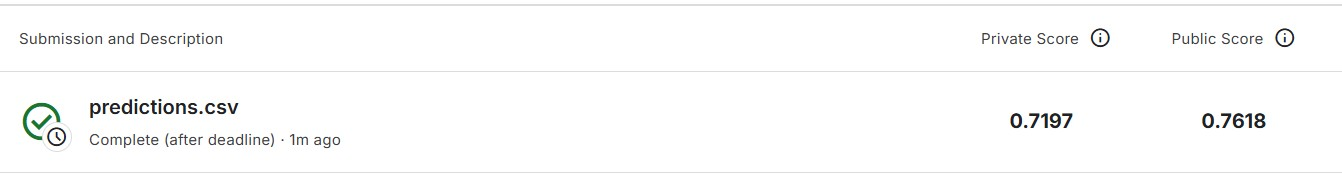